# Taxi Cost Prediction using Linear Regression 

In [3]:
import numpy as np
from sklearn import datasets, linear_model, metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import math

In [19]:
def side_by_side(*objs, **kwds):
    from pandas.io.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))
    print()
    return

# 1. Data Loading and Cleaning 

##### There are data is loaded from two separate tables. The first table contains data about travel (features w) and the second table contains our target value, y (cost of the travel).  

In [71]:
start = datetime.now()
# taxiOrdersDF is feature set 
taxiOrdersDF = pd.read_csv('./orders_2019.csv', sep=';', 
                           usecols=["id", "client_id", "driver_id", "status", "from_adres", "coord_from_adres", 
                                   "to_adres", "coord_to_adres", "date", "dateRequest", "tariffID", "payment_type_id", 
                                   "order_from_lat", "order_from_lon", "order_to_lat", "order_to_lon", "geozone_id"],
                           encoding = 'UTF-8')

# taxiOrdersDetailsDF is target value (label)  
taxiOrdersDetailsDF = pd.read_csv('./order_details_2019.csv', sep=';',
                                   usecols=["order_id", "total_cost"], encoding = 'UTF-8')
print("Computing time takes %s" %(datetime.now()-start))

Computing time takes 0:00:06.751125


#### Info about data

In [72]:
print(taxiOrdersDF.columns)
print(taxiOrdersDetailsDF.columns)

Index(['id', 'client_id', 'driver_id', 'status', 'from_adres',
       'coord_from_adres', 'to_adres', 'coord_to_adres', 'date', 'dateRequest',
       'tariffID', 'payment_type_id', 'geozone_id', 'order_from_lat',
       'order_from_lon', 'order_to_lat', 'order_to_lon'],
      dtype='object')
Index(['order_id', 'total_cost'], dtype='object')


In [73]:
taxiOrdersDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697585 entries, 0 to 697584
Data columns (total 17 columns):
id                  697585 non-null int64
client_id           694462 non-null float64
driver_id           569763 non-null float64
status              697583 non-null float64
from_adres          697339 non-null object
coord_from_adres    697404 non-null object
to_adres            515520 non-null object
coord_to_adres      697404 non-null object
date                697585 non-null object
dateRequest         697585 non-null object
tariffID            697585 non-null int64
payment_type_id     697585 non-null int64
geozone_id          694281 non-null float64
order_from_lat      697404 non-null float64
order_from_lon      697404 non-null float64
order_to_lat        697404 non-null float64
order_to_lon        697404 non-null float64
dtypes: float64(8), int64(3), object(6)
memory usage: 90.5+ MB


### Checking missing records which contains null values, they should be cleaned 

In [74]:
side_by_side(taxiOrdersDF.isnull().sum(), taxiOrdersDF.count())

id                       0    id                  697585
client_id             3123    client_id           694462
driver_id           127822    driver_id           569763
status                   2    status              697583
from_adres             246    from_adres          697339
coord_from_adres       181    coord_from_adres    697404
to_adres            182065    to_adres            515520
coord_to_adres         181    coord_to_adres      697404
date                     0    date                697585
dateRequest              0    dateRequest         697585
tariffID                 0    tariffID            697585
payment_type_id          0    payment_type_id     697585
geozone_id            3304    geozone_id          694281
order_from_lat         181    order_from_lat      697404
order_from_lon         181    order_from_lon      697404
order_to_lat           181    order_to_lat        697404
order_to_lon           181    order_to_lon        697404
dtype: int64                  d

In [75]:
side_by_side(taxiOrdersDetailsDF.isnull().sum(), taxiOrdersDetailsDF.count())

order_id      0    order_id      498787
total_cost    0    total_cost    498787
dtype: int64       dtype: int64        



In [76]:
taxiOrdersDF.status[taxiOrdersDF.status == 7].count()

498764

### Data preprocessing

In [77]:
start = datetime.now()
taxiOrdersDF['date'] = taxiOrdersDF['date'].astype('datetime64[ns]')
taxiOrdersDF['dateRequest'] = taxiOrdersDF['dateRequest'].astype('datetime64[ns]')
print("Computing time takes %s" %(datetime.now()-start))

Computing time takes 0:00:47.235924


### Now, let's join these two tables 

In [78]:
taxiOrdersDF['id'] = taxiOrdersDF['id'].astype('int64')
taxiOrdersDF.rename(columns={'id':'order_id'}, inplace=True)
taxiOrdersJoinTotalCostDF = pd.merge(taxiOrdersDF, taxiOrdersDetailsDF, on='order_id', how='inner')

In [79]:
side_by_side(taxiOrdersJoinTotalCostDF.isnull().sum(), taxiOrdersJoinTotalCostDF.count())

order_id               0    order_id            498786
client_id           3084    client_id           495702
driver_id              0    driver_id           498786
status                 0    status              498786
from_adres            64    from_adres          498722
coord_from_adres       0    coord_from_adres    498786
to_adres              19    to_adres            498767
coord_to_adres         0    coord_to_adres      498786
date                   0    date                498786
dateRequest            0    dateRequest         498786
tariffID               0    tariffID            498786
payment_type_id        0    payment_type_id     498786
geozone_id          3084    geozone_id          495702
order_from_lat         0    order_from_lat      498786
order_from_lon         0    order_from_lon      498786
order_to_lat           0    order_to_lat        498786
order_to_lon           0    order_to_lon        498786
total_cost             0    total_cost          498786
dtype: int

#### By joining these two tables, many missing records are cleaned.

### Clean missing records 

In [82]:
taxiOrdersJoinTotalCostDF.dropna(inplace=True)

In [83]:
side_by_side(taxiOrdersJoinTotalCostDF.isnull().sum(), taxiOrdersJoinTotalCostDF.count())

order_id            0    order_id            495683
client_id           0    client_id           495683
driver_id           0    driver_id           495683
status              0    status              495683
from_adres          0    from_adres          495683
coord_from_adres    0    coord_from_adres    495683
to_adres            0    to_adres            495683
coord_to_adres      0    coord_to_adres      495683
date                0    date                495683
dateRequest         0    dateRequest         495683
tariffID            0    tariffID            495683
payment_type_id     0    payment_type_id     495683
geozone_id          0    geozone_id          495683
order_from_lat      0    order_from_lat      495683
order_from_lon      0    order_from_lon      495683
order_to_lat        0    order_to_lat        495683
order_to_lon        0    order_to_lon        495683
total_cost          0    total_cost          495683
dtype: int64             dtype: int64              



#### Data is clean now without any null value

In [86]:
taxiOrdersJoinTotalCostDF.drop(["order_id"], axis=1, inplace = True) 
taxiOrdersDF = taxiOrdersJoinTotalCostDF # rename taxiOrdersJoinTotalCostDF 

# 2. Data Wrangling and Features Engineering

In [87]:
taxiOrdersDF.describe().T 

,count,mean,std,min,25%,50%,75%,max
client_id,495683.0,123844.505950,71777.427859,641.000000,61088.000000,123652.000000,185933.000000,2.575590e+05
driver_id,495683.0,4862.048715,1751.409890,23.000000,4107.000000,5168.000000,6305.000000,7.598000e+03
status,495683.0,7.006803,0.324455,2.000000,7.000000,7.000000,7.000000,2.500000e+01
tariffID,495683.0,12.445726,16.372089,1.000000,1.000000,1.000000,29.000000,6.900000e+01
payment_type_id,495683.0,1.119163,0.414902,1.000000,1.000000,1.000000,1.000000,4.000000e+00
geozone_id,495683.0,3.079393,0.869007,3.000000,3.000000,3.000000,3.000000,1.400000e+01
order_from_lat,495683.0,41.305949,0.045994,40.728624,41.292072,41.307184,41.325185,4.162943e+01
order_from_lon,495683.0,69.292684,0.213410,69.121891,69.258995,69.278161,69.298261,7.239590e+01
order_to_lat,495683.0,41.302248,0.369533,0.000000,41.290665,41.307402,41.326379,4.165737e+01
order_to_lon,495683.0,69.286350,0.704719,-120.924671,69.255708,69.277839,69.300326,7.256801e+01


### Correlation between data 

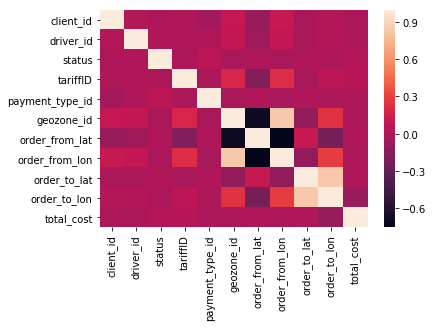

In [89]:
corr = taxiOrdersDF.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# 3. Training and Evaluating Machine Learning Model

In [90]:
taxiOrdersDF.shape

(495683, 17)

In [117]:
taxiOrders_Y = taxiOrdersDF["total_cost"]
taxiOrders_X = taxiOrdersDF
taxiOrders_X.drop(["total_cost", "date", "dateRequest"], axis=1, inplace = True) 
taxiOrders_X.drop(["from_adres", "coord_from_adres", "to_adres", "coord_to_adres"], axis=1, inplace = True) 

# Split the data into training/testing sets
taxiOrders_X_train = taxiOrders_X[:-200]
taxiOrders_X_test = taxiOrders_X[-200:]

# Split the targets into training/testing sets
taxiOrders_Y_train = taxiOrders_Y[:-200]
taxiOrders_Y_test = taxiOrders_Y[-200:]

In [104]:
taxiOrders_X.drop(["from_adres", "coord_from_adres", "to_adres", "coord_to_adres"], axis=1, inplace = True) 

### 3.1 Train

In [ ]:
X = taxiOrders_X_train
Y = taxiOrders_Y_train

# choosing weights and bias randomly 
W = np.random.uniform(low=-0.1, high=0.1, size=taxiOrders_X.shape[1])
b = 0.0

learning_rate = 0.0000000001
epochs = 1000

# train: gradient descent
for i in range(epochs):
    # calculate predictions
    y_predict = X.dot(W) + b
 
    # calculate error and cost (mean squared error)
    error = Y - y_predict
    mean_squared_error = np.mean(np.power(error, 2))
 
    # calculating gradients
    W_gradient = -(1.0/len(X)) * error.dot(X)
    b_gradient = -(1.0/len(X)) * np.sum(error)
 
    # updating parameters
    W = W - (learning_rate * W_gradient)
    b = b - (learning_rate * b_gradient)
 
    if i % 5 == 0: 
        print("Epoch %d: %f" % (i, mean_squared_error))

In [131]:
# test
X = taxiOrders_X_test
y = taxiOrders_Y_test
 
y_predict = X.dot(W) + b
for i in y_predict: 
    print (i)
error = y - y_predict
mean_squared_error = np.mean(np.power(error, 2))
print("Mean squared error: %.2f" % mean_squared_error)
print("="*120)

-955865323481263.6
-538611133081166.9
-1019769177932823.6
-698823337761388.2
-690120197113429.1
-417561016813799.2
-576993731843810.9
-523944880952435.1
-311345112435004.5
-747729469803542.5
-368536800984045.7
-769373557356924.2
-1051249628097842.5
-794333165715103.0
-263030982889185.8
-5790864876096.755
-175904249704987.72
-1018742012365193.0
-37187678927049.83
-136053417426605.06
-1075519993214728.5
-916962411422242.6
-769531266659681.1
-587332378817155.5
-667766714719083.9
-693629033392238.9
-467392523622388.06
-1014968072969638.1
-123868713125023.31
-1086288906848494.6
-161343800090371.78
-451419549433413.44
-815165554627307.1
-952005146635027.2
-918409126056659.1
-46387373839367.96
-510758800875175.94
-635544413663073.2
-442254013713559.9
-609793074994182.5
-905718034667720.2
-434258582055106.94
-56114991545889.26
-699030107438225.2
-791818530846499.5
-668863927175585.4
-410741303847355.4
-267323962096505.78
-712971219527773.4
-924024734677924.8
-226661745449250.12
-41010008595671